In [2]:
# general
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2

# torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import random_split

### Structure
- plot images
- text preprocessing
- data loader
- image augmentation

### Plot images

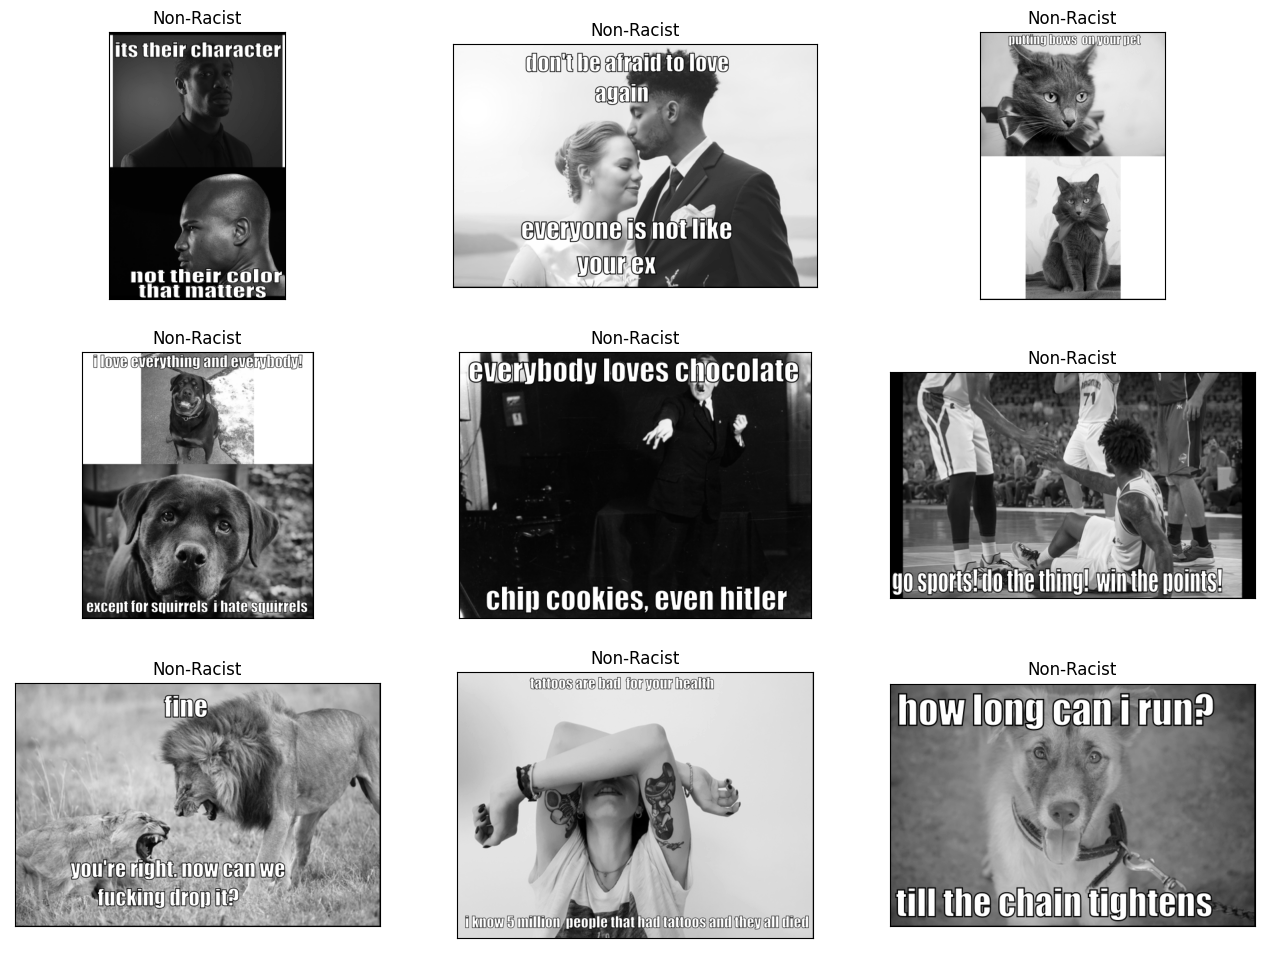

In [63]:
dataset_df = pd.read_json('../data/train.jsonl', lines=True)

# plot a few images together with labels
nx = 3
ny = 3

fig, ax = plt.subplots(figsize=(16, ny*4), nrows=ny, ncols=nx)
for i in range(ny):
    for j in range(nx):
        img_id = dataset_df['id'].values[i*nx+ j]
        
        # catch trailing 0
        if img_id < 1e4:
            img = cv2.imread('../data/img/0'+str(img_id)+ '.png', cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread('../data/img/'+str(img_id)+ '.png', cv2.IMREAD_GRAYSCALE)  
        
        # plot and remove axes
        ax[i,j].imshow(img, cmap='gray')
        ax[i,j].set_title('Racist' if dataset_df['label'].values[i*nx+ j] else 'Non-Racist')
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)
        
plt.show()

### Text Preprocessing

Bert requires: <br>
- tokenization
- special characters
- padding
- mask

techniques to try (for other models): <br>
- Lower casing
- Punctuation removal
- Stopwords removal
- Frequent words removal
- Rare words removal
- Spelling correction
- Tokenization
- Stemming
- Lemmatization
- word embedding/ bag of words

In [66]:
path_text = '../data/train.jsonl'

# read text
dataset_df = pd.read_json(path_text, lines=True)
dataset_df.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [67]:
# dictionary
data = dataset_df.to_dict(orient='records') # have been shuffled in previous step

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

# train valid split
train_data, valid_data = random_split(data, [train_size, val_size])

In [68]:
# split into text (input) and labels (output)
train_texts, train_imgs, train_labels = list(zip(*map(lambda d: (d['text'], d['img'], d['id']), train_data)))
valid_texts, valid_imgs, valid_labels = list(zip(*map(lambda d: (d['text'], d['img'], d['id']), valid_data)))

len(train_texts), len(train_labels), len(valid_texts), len(valid_labels)

(6800, 6800, 1700, 1700)

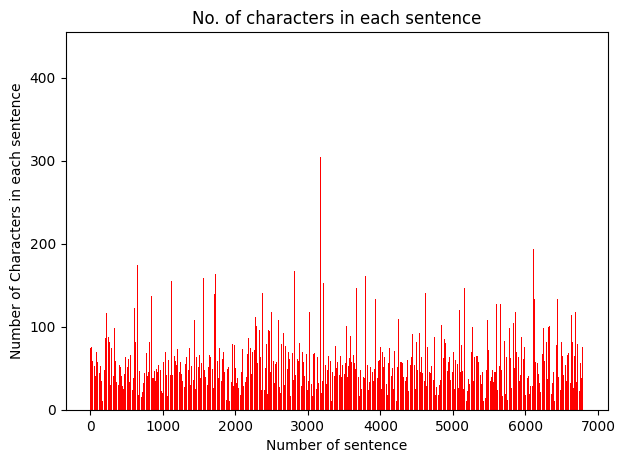

In [69]:
# analysis of review length
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,len(train_texts)+1), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

# -> bert with 64 tokens should be sufficient

In [70]:
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

# bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [71]:
# token embeddings with required separation token
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:62] + ['[SEP]'], train_texts))
valid_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:62] + ['[SEP]'], valid_texts))

len(train_tokens), len(valid_tokens)

(6800, 1700)

In [72]:
# prepare token ids: each token (word fragment) corresponds to an id in the bert corpus
# further need to make all review the same length -> padding too short, truncating too long ones
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=64, truncating="post", padding="post", dtype="int")
valid_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, valid_tokens)), maxlen=64, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, valid_tokens_ids.shape

((6800, 64), (1700, 64))

In [75]:
# mask for padding -> required by bert
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
valid_masks = [[float(i > 0) for i in ii] for ii in valid_tokens_ids]

In [86]:
# put everything back into a dictionary
data_train = {'img_names': train_imgs, 'tokens': train_tokens, 'token_ids': train_tokens_ids,
              'masks': train_masks, 'labels': train_labels}

## Dataloader

In [89]:
class HatefulMemesDataset(Dataset):
    """ Hateful Memes dataset """
    
    def __init__(self, data, img_dir, normalize=False, transform=None):
        """
        Args:
            df_path (string): path to jsonl file with image id's
            root_dir (string): directory with all the images
            transform (callable): optional transform to be applied on a sample
        """
        # text
        self.data = data
        
        # image
        self.img_dir = img_dir
        self.normalize = normalize
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx_tolist()
            
            
        data_train = {'img_names': train_imgs, 'tokens': train_tokens, 'token_ids': train_tokens_ids,
              'masks': train_masks, 'labels': train_labels}
        
        # load image
        img_name = os.path.join(self.img_dir, str(self.data['img_names'][idx]))
        image = cv2.imread(img_name)
        
        if self.normalize:
            # TODO: normalize image by mean and std -> what data type do networks require?
            print('TODO')
        
        # token
        token = self.data['tokens'][idx]
        token_id = self.data['token_ids'][idx]
        
        # label
        label = self.data['labels'][idx]
        label = np.array([label])
        label = label.astype('int').reshape(-1)
        
        # mask
        mask = self.data['masks'][idx]
        
        #
        sample = {'image': image, 'token': token, 'token_id': token_id, 'mask': mask, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

0 (549, 825, 3) (1,)
['[CLS]', 'there', 'is', 'no', 'hind', '##u', 'terrorism', 'in', 'in', '##dia', '.', 'what', 'if', 'i', 'say', 'it', 'isn', "'", 't', 'true', '?', 'will', 'shoot', 'you', 'dead', '[SEP]']
1 (800, 315, 3) (1,)
['[CLS]', 'my', 'customer', 'service', 'face', 'vs', 'how', 'i', 'actually', 'feel', '[SEP]']
2 (800, 800, 3) (1,)
['[CLS]', 'we', 'said', 'we', 'would', 'never', 'forget', 'why', 'are', 'you', 'voting', 'them', 'into', 'our', 'government', '?', '[SEP]']
3 (533, 800, 3) (1,)
['[CLS]', 'every', 'time', 'a', 'person', 'is', 'offended', 'on', 'social', 'media', 'a', 'vote', 'is', 'cast', 'for', 't', '##rump', '[SEP]']


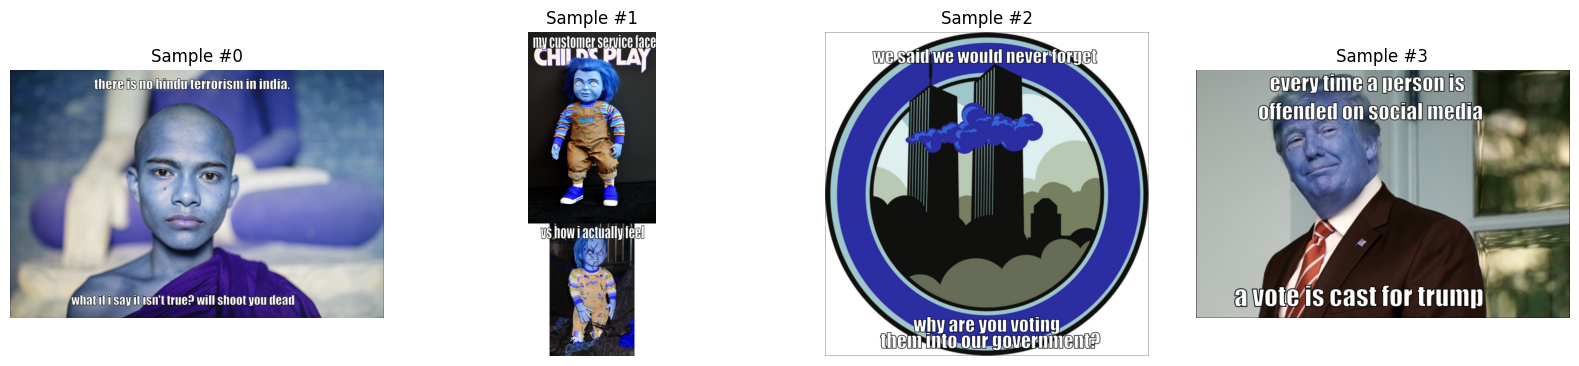

In [98]:
memes_dataset = HatefulMemesDataset(data_train, img_dir='../data', normalize=False)

fig = plt.figure(figsize=(16, 4))

for i in range(len(memes_dataset)):
    sample = memes_dataset[i]

    print(i, sample['image'].shape, sample['label'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    #ax.set_xlabel(sample['text'])
    print(sample['token'])
    ax.axis('off')
    
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

## Image augmentation

In [102]:
# aspect ratio = 1.3 (width / height) median
# image dimensions = 128 x 128 (16k pixels) for CNN's

class Rescale(object):
    """Rescale the image in a sample to a given size
    Args:
        img_width (int): desired width of image
        max_distortion (float): maximum distortion of an image in a given direction
    """
    
    def __init__(self, size, max_distortion):
        self.size = size
        self.max_distortion = max_distortion
        
    def __call__(self, sample):
        image, token, token_id, mask, label = sample['image'], sample['token'], sample['token_id'], sample['mask'], sample['label']

        #
        width, height = image.shape[:2]
        aspect_ratio = width/ height
        
        # resulting distortion too high -> padding
        if aspect_ratio > self.max_distortion:
            pad = width- 2*height
            img = cv2.copyMakeBorder(image, int(pad/2.), int(pad/2.), 0, 0, cv2.BORDER_CONSTANT)
        elif 1./aspect_ratio > self.max_distortion:
            pad = height- 2*width
            img = cv2.copyMakeBorder(image, 0, 0, int(pad/2.), int(pad/2.), cv2.BORDER_CONSTANT)
        else:
            img = image.copy()
            
        # resize image
        img = transform.resize(img, (self.size, self.size))
        
        return {'image': img, 'token': token, 'token_id': token_id, 'mask': mask, 'label': label}

In [103]:
# cropping, scaling, rotation, noise, color?
class Transform(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self):
        pass
        
    def __call__(self, sample):
        image, token, token_id, mask, label = sample['image'], sample['token'], sample['token_id'], sample['mask'], sample['label']
        
        transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.RandomRotation(degrees=(-20, 20))])
        
        img = (255.* image).astype(np.uint8)
        img = transform(img.astype(np.uint8))
        
        
        return {'image': img, 'token': token, 'token_id': token_id, 'mask': mask, 'label': label}

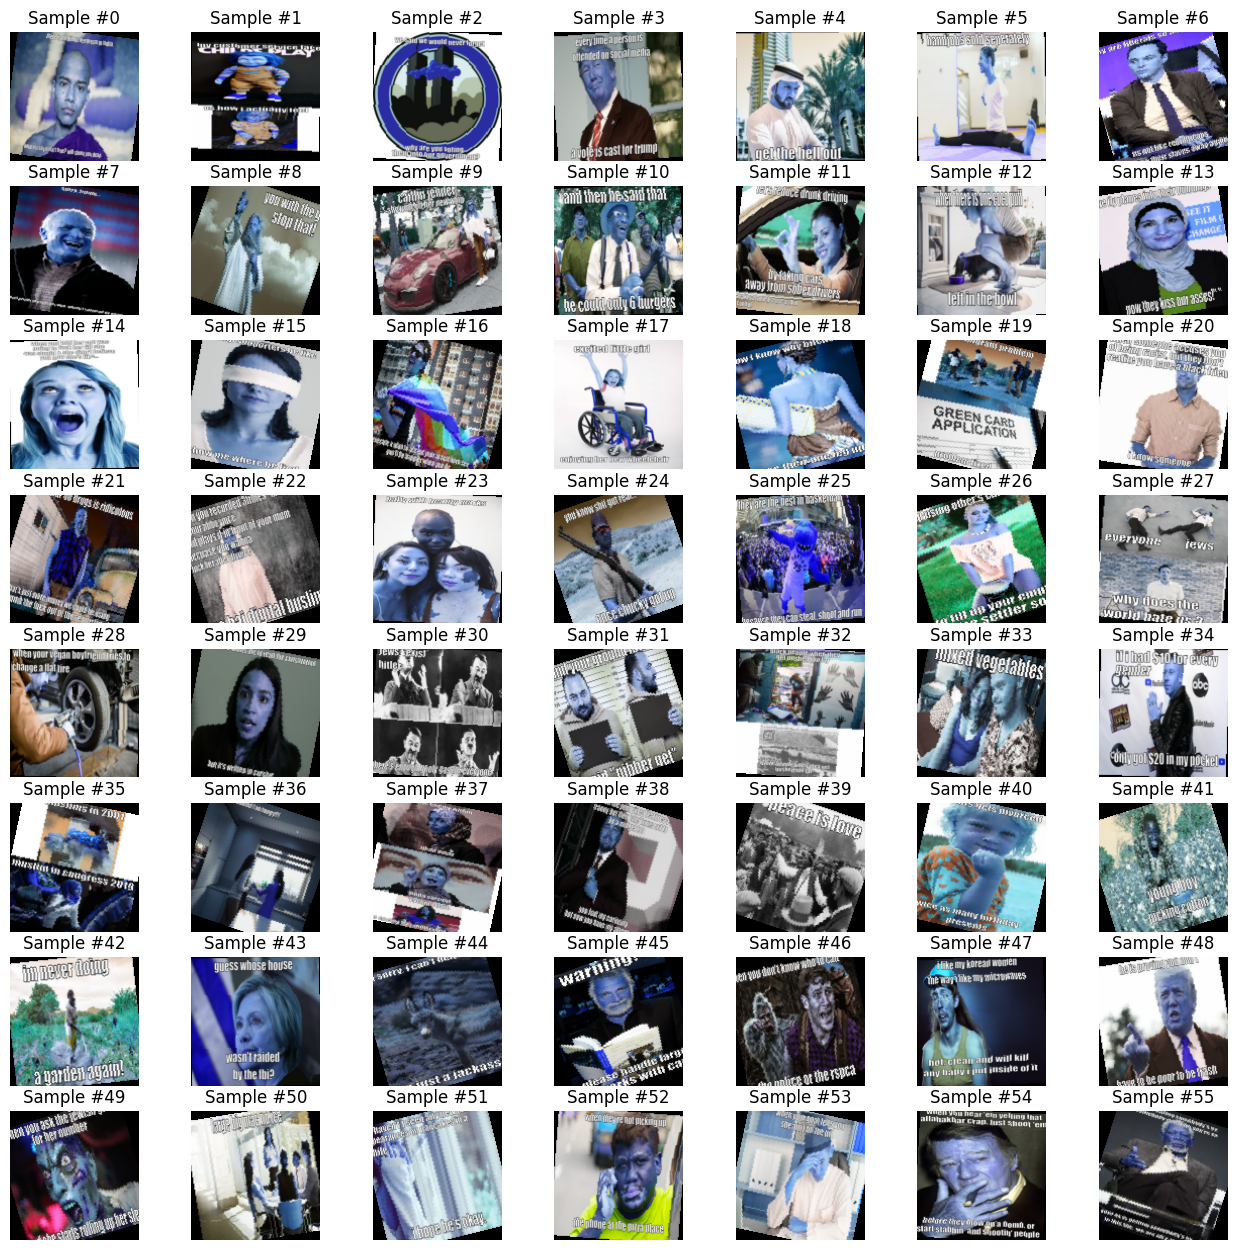

In [108]:
# dataset
composed = transforms.Compose([Rescale(128, 2.),
                               Transform()])

memes_dataset = HatefulMemesDataset(data_train, img_dir='../data',
                                    normalize=False, transform=composed)

#plot
ncols = 7
nrows = 8
fig, ax = plt.subplots(figsize=(16, 16), ncols=ncols, nrows=nrows)

for i in range(ncols*nrows):
    x = i%ncols 
    y = int(i/ncols)
    
    sample = memes_dataset[i]

    ax[y,x].imshow(sample['image'])
    ax[y,x].set_title('Sample #{}'.format(i))
    ax[y,x].axis('off')

plt.show()